In [1]:
import zipfile
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
!pip install pretrainedmodels

     |████████████████████████████████| 61kB 4.7MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60962 sha256=7cc0f6248b2ecf4c47eeb1dabc8ab944a54f7b2435877c5951c40efaac713302
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built pretrainedmodels


In [3]:
!pip install --user --upgrade efficientnet-pytorch
!pip install --user --upgrade albumentations

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp36-none-any.whl size=12422 sha256=97410b9665ec31b0458b821e5f52ea5fe1a572ad94b0728f559b0f9820de3648
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
Successfully built efficientnet-pytorch
     |████████████████████████████████| 122kB 8.2MB/s 
     |████████████████████████████████| 952kB 7.2MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp36-none-any.whl size=65164 sha256=a523b94644e4e1238e005fa88772facaa2922a89f62f281a8025961dc59e95d2
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations


In [4]:
!pip install iterative-stratification

In [2]:
import pandas as pd
import numpy as np
import os
import joblib
import glob
from tqdm import tqdm
import albumentations
import torch
import torch.nn as nn
from sklearn import metrics
import pretrainedmodels
from torch.nn import functional as F
from PIL import Image
from albumentations.core.transforms_interface import ImageOnlyTransform
from albumentations.augmentations import functional as F1
from PIL import Image, ImageOps, ImageEnhance
from sklearn import model_selection
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader, random_split 
from albumentations.core.transforms_interface import DualTransform
from efficientnet_pytorch import EfficientNet
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt



In [3]:
!unzip '/content/drive/My Drive/hackerearth_contest.zip'

Archive:  /content/drive/My Drive/hackerearth_contest.zip
   creating: dataset/
   creating: dataset/test/
  inflating: dataset/test/508.jpg    
  inflating: dataset/test/246.jpg    
  inflating: dataset/test/473.jpg    
  inflating: dataset/test/485.jpg    
  inflating: dataset/test/128.jpg    
  inflating: dataset/test/410.jpg    
  inflating: dataset/test/465.jpg    
  inflating: dataset/test/196.jpg    
  inflating: dataset/test/340.jpg    
  inflating: dataset/test/467.jpg    
  inflating: dataset/test/306.jpg    
  inflating: dataset/test/171.jpg    
  inflating: dataset/test/323.jpg    
  inflating: dataset/test/332.jpg    
  inflating: dataset/test/330.jpg    
  inflating: dataset/test/170.jpg    
  inflating: dataset/test/479.jpg    
  inflating: dataset/test/9.jpg      
  inflating: dataset/test/283.jpg    
  inflating: dataset/test/114.jpg    
  inflating: dataset/test/507.jpg    
  inflating: dataset/test/183.jpg    
  inflating: dataset/test/200.jpg    
  inflating: datase

In [ ]:
# ls 'dataset/train/'

In [4]:
train_df = pd.read_csv('dataset/train.csv')
test_df = pd.read_csv('dataset/test.csv')

In [5]:
train_df.head()

,Image,target
0,96.jpg,manipuri
1,163.jpg,bharatanatyam
2,450.jpg,odissi
3,219.jpg,kathakali
4,455.jpg,odissi


In [6]:
train_df['target'].unique()

array(['manipuri', 'bharatanatyam', 'odissi', 'kathakali', 'kathak',
       'sattriya', 'kuchipudi', 'mohiniyattam'], dtype=object)

In [7]:
labelencoder = LabelEncoder()
train_df['target_id'] = labelencoder.fit_transform(train_df['target'])

In [8]:
train_df.head()

,Image,target,target_id
0,96.jpg,manipuri,4
1,163.jpg,bharatanatyam,0
2,450.jpg,odissi,6
3,219.jpg,kathakali,2
4,455.jpg,odissi,6


In [58]:
original_values = dict()
for item, row in train_df.iterrows():
  original_values[row['target_id']]=row['target']

In [10]:
train_df["kfold"] = -1
train_df = train_df.sample(frac=1).reset_index(drop=True)
y = train_df.target.values
kf = model_selection.StratifiedKFold(n_splits=5)
for f, (t_, v_) in enumerate(kf.split(X=train_df, y=y)):
    train_df.loc[v_, 'kfold'] = f

train_df.to_csv("train_folds.csv", index=False)

In [11]:
class IndianDanceFormsDataset(Dataset):
  def __init__(self, train_df, train_dir, transform=None):
    self.train_df = train_df
    self.train_dir = train_dir
    self.transform = transform
  
  def __len__(self):
    return len(self.train_df)
  
  def __getitem__(self,idx):
    row = self.train_df.loc[idx]
    img_id, label = row['Image'], row['target_id']
    img = Image.open(os.path.join(self.train_dir, img_id))
    if self.transform:
      img = self.transform(img)
    return {
            'image': img,
            'target': label
            } 

In [12]:
class EfficientNetB7(nn.Module):
    def __init__(self, pretrained):
        super(EfficientNetB7, self).__init__()
        self.base_model = EfficientNet.from_pretrained("efficientnet-b7")        
        self.l0 = nn.Linear(2560, 8)

    def forward(self, image):
        batch_size, _, _, _ = image.shape
        x = self.base_model.extract_features(image)
        x = F.adaptive_avg_pool2d(x,1).reshape(batch_size,-1)
        out = (self.l0(x))
        return out

In [13]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss


In [37]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
EPOCHS = 10
TRAIN_BATCH_SIZE = 16
TEST_BATCH_SIZE = 16
TRAIN_DIR = 'dataset/train'
TEST_DIR = 'dataset/test'

In [15]:
def loss_fn(outputs, targets):
  return nn.CrossEntropyLoss()(outputs, targets)

In [16]:
def get_accuracy(logits, labels):
  predictions = np.argmax(F.softmax(logits,dim=1).cpu().data.numpy(),axis=1)
  label = labels.cpu()
  total_num = 0
  sum_correct = 0
  for i in range(len(labels)):
    if labels[i]>=0:
      total_num+=1
      if predictions[i] == labels[i]:
        sum_correct += 1
  if total_num==0:
    total_num = 1e-7
  return np.float32(sum_correct)/total_num

In [17]:
def train(dataset, data_loader, model, optimizer):
  model.train()
  final_loss = 0
  counter = 0
  final_accuracy = 0
  for bi, d in tqdm(enumerate(data_loader),total=int(len(dataset)/data_loader.batch_size)):
    counter = counter + 1
    image = d["image"]
    target = d["target"]
    image = image.to(DEVICE, dtype = torch.float)
    targets = target.to(DEVICE, dtype = torch.long)
    optimizer.zero_grad()
    outputs = model(image)
    loss = loss_fn(outputs, targets)
    loss.backward()
    optimizer.step()
    final_loss += loss
    acc = get_accuracy(outputs, targets)
    final_accuracy += acc
  print("=================TRAIN==================")
  print(f"accuracy = {final_accuracy/counter},  loss = {final_loss/counter}")
  return final_loss/counter , final_accuracy/counter

In [18]:
def evaluate(dataset, data_loader, model):
  with torch.no_grad():
    model.eval()
    final_loss = 0
    counter = 0
    final_accuracy = 0
    for bi, d in tqdm(enumerate(data_loader), total = int(len(dataset)/data_loader.batch_size)):
      counter += 1
      image = d["image"]
      targets = d["target"]
      image = image.to(DEVICE, dtype = torch.float)
      targets = targets.to(DEVICE, dtype = torch.long)
      outputs = model(image)
      loss = loss_fn(outputs, targets)
      final_loss += loss
      acc = get_accuracy(outputs, targets)
      final_accuracy += acc
  print("=================VALID==================")
  print(f"accuracy = {final_accuracy/counter},  loss = {final_loss/counter}")
  return final_loss/counter, final_accuracy/counter


In [19]:
# transforms
padding = (10, 15, 20, 30)
train_transform = transforms.Compose([
                                transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(degrees=(-10,+10)),
                                transforms.RandomAffine(0, translate=None, scale=(0.9, 1.1), shear=1, resample=False, fillcolor=0),
                                transforms.Pad(padding, fill=0, padding_mode='reflect'),
                                transforms.Resize(size=(224, 224)),
#                                 transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                ])
valid_transform = transforms.Compose([
                                transforms.Resize(size=(224, 224)),
#                                 transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                ])

In [20]:
def main(fold,df):
  df_train = df[df.kfold != fold].reset_index(drop=True)
  df_valid = df[df.kfold == fold].reset_index(drop=True)
  model = EfficientNetB7(pretrained=True)
  model.to(DEVICE)
  train_dataset = IndianDanceFormsDataset(
      train_df = df_train,
      train_dir = TRAIN_DIR,
      transform = train_transform
  )
  train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size= TRAIN_BATCH_SIZE,
        shuffle=True,
        num_workers=4
    )
  valid_dataset = IndianDanceFormsDataset(
      train_df = df_valid,
      train_dir = TRAIN_DIR,
      transform = valid_transform
  )
  valid_loader = torch.utils.data.DataLoader(
        dataset=valid_dataset,
        batch_size= TEST_BATCH_SIZE,
        shuffle=False,
        num_workers=4
  )
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                            mode="min", 
                                                            patience=5, 
                                                            factor=0.3,verbose=True)
  early_stopping = EarlyStopping(patience=5, verbose=True)
  if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
  best_acc = -1
  print("FOLD : ", fold)
  val_scores = []
  for epoch in range(1, EPOCHS+1):
    train_loss, train_acc = train(train_dataset, train_loader, model, optimizer)
    valid_loss, valid_acc = evaluate(valid_dataset, valid_loader, model)
    scheduler.step(valid_loss)
    if valid_acc > best_acc:
      best_acc = valid_acc
      torch.save(model.state_dict(), "model_fold_{}.pth".format(fold))
    epoch_len = len(str(EPOCHS))
    print_msg = (f'[{epoch:>{epoch_len}}/{EPOCHS:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'train_acc: {train_acc:.5f} ' +
                     f'valid_loss: {valid_loss:.5f} ' +
                     f'valid_acc: {valid_acc:.5f}'
                    )
    val_scores.append(valid_acc)
    print(print_msg)
    early_stopping(valid_loss, model)
    if early_stopping.early_stop:
      print("Early stopping")
      break
  plt.style.use('ggplot')
  plt.figure()
  plt.plot(np.arange(0, len(val_scores)), val_scores, label='val_scores')
  plt.title('accuracy Score')
  plt.xlabel('# of epochs')
  plt.ylabel('accuracy Score')
  plt.legend(loc='lower right')
  plt.show()

In [21]:
train_df = pd.read_csv('train_folds.csv')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/checkpoints/efficientnet-b7-dcc49843.pth



Loaded pretrained weights for efficientnet-b7
FOLD :  0


19it [00:11,  1.61it/s]

=================TRAIN==================
accuracy = 0.31359649122807015,  loss = 1.9933750629425049



5it [00:01,  4.23it/s]                       


=================VALID==================
accuracy = 0.3736111111111111,  loss = 1.9279435873031616
[ 1/10] train_loss: 1.99338 train_acc: 0.31360 valid_loss: 1.92794 valid_acc: 0.37361
Validation loss decreased (inf --> 1.927944).  Saving model ...


19it [00:11,  1.65it/s]

=================TRAIN==================
accuracy = 0.6995614035087719,  loss = 1.5628474950790405



5it [00:01,  4.20it/s]                       


=================VALID==================
accuracy = 0.5361111111111111,  loss = 1.6033241748809814
[ 2/10] train_loss: 1.56285 train_acc: 0.69956 valid_loss: 1.60332 valid_acc: 0.53611
Validation loss decreased (1.927944 --> 1.603324).  Saving model ...


19it [00:11,  1.66it/s]

=================TRAIN==================
accuracy = 0.787280701754386,  loss = 1.101426362991333



5it [00:01,  4.29it/s]                       


=================VALID==================
accuracy = 0.5958333333333333,  loss = 1.2140071392059326
[ 3/10] train_loss: 1.10143 train_acc: 0.78728 valid_loss: 1.21401 valid_acc: 0.59583
Validation loss decreased (1.603324 --> 1.214007).  Saving model ...


19it [00:11,  1.68it/s]

=================TRAIN==================
accuracy = 0.8640350877192983,  loss = 0.682379424571991



5it [00:01,  4.18it/s]                       


=================VALID==================
accuracy = 0.6930555555555555,  loss = 0.9837394952774048
[ 4/10] train_loss: 0.68238 train_acc: 0.86404 valid_loss: 0.98374 valid_acc: 0.69306
Validation loss decreased (1.214007 --> 0.983739).  Saving model ...


19it [00:11,  1.66it/s]

=================TRAIN==================
accuracy = 0.9539473684210527,  loss = 0.4043830633163452



5it [00:01,  4.08it/s]                       


=================VALID==================
accuracy = 0.7680555555555555,  loss = 0.7668561935424805
[ 5/10] train_loss: 0.40438 train_acc: 0.95395 valid_loss: 0.76686 valid_acc: 0.76806
Validation loss decreased (0.983739 --> 0.766856).  Saving model ...


19it [00:11,  1.65it/s]

=================TRAIN==================
accuracy = 0.9671052631578947,  loss = 0.23986639082431793



5it [00:01,  4.35it/s]                       


=================VALID==================
accuracy = 0.8277777777777778,  loss = 0.6209527254104614
[ 6/10] train_loss: 0.23987 train_acc: 0.96711 valid_loss: 0.62095 valid_acc: 0.82778
Validation loss decreased (0.766856 --> 0.620953).  Saving model ...


19it [00:11,  1.66it/s]

=================TRAIN==================
accuracy = 0.9660087719298246,  loss = 0.22090992331504822



5it [00:01,  4.16it/s]                       


=================VALID==================
accuracy = 0.8277777777777778,  loss = 0.5916391015052795
[ 7/10] train_loss: 0.22091 train_acc: 0.96601 valid_loss: 0.59164 valid_acc: 0.82778
Validation loss decreased (0.620953 --> 0.591639).  Saving model ...


19it [00:11,  1.64it/s]

=================TRAIN==================
accuracy = 0.9967105263157895,  loss = 0.08027153462171555



5it [00:01,  4.11it/s]                       

=================VALID==================
accuracy = 0.8277777777777778,  loss = 0.622902512550354
[ 8/10] train_loss: 0.08027 train_acc: 0.99671 valid_loss: 0.62290 valid_acc: 0.82778
EarlyStopping counter: 1 out of 5



19it [00:11,  1.67it/s]

=================TRAIN==================
accuracy = 0.9868421052631579,  loss = 0.11352227628231049



5it [00:01,  4.15it/s]                       


=================VALID==================
accuracy = 0.8152777777777779,  loss = 0.5863952040672302
[ 9/10] train_loss: 0.11352 train_acc: 0.98684 valid_loss: 0.58640 valid_acc: 0.81528
Validation loss decreased (0.591639 --> 0.586395).  Saving model ...


19it [00:11,  1.60it/s]

=================TRAIN==================
accuracy = 0.993421052631579,  loss = 0.07427769154310226



5it [00:01,  4.12it/s]                       


=================VALID==================
accuracy = 0.8402777777777779,  loss = 0.5441588759422302
[10/10] train_loss: 0.07428 train_acc: 0.99342 valid_loss: 0.54416 valid_acc: 0.84028
Validation loss decreased (0.586395 --> 0.544159).  Saving model ...


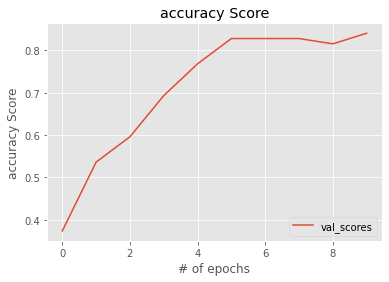

In [22]:
main(0,train_df)

Loaded pretrained weights for efficientnet-b7
FOLD :  1


19it [00:11,  1.66it/s]

=================TRAIN==================
accuracy = 0.2675438596491228,  loss = 2.0112342834472656



5it [00:01,  3.91it/s]                       


=================VALID==================
accuracy = 0.3194444444444445,  loss = 1.9685182571411133
[ 1/10] train_loss: 2.01123 train_acc: 0.26754 valid_loss: 1.96852 valid_acc: 0.31944
Validation loss decreased (inf --> 1.968518).  Saving model ...


19it [00:11,  1.63it/s]

=================TRAIN==================
accuracy = 0.7280701754385965,  loss = 1.6055470705032349



5it [00:01,  3.84it/s]                       


=================VALID==================
accuracy = 0.5541666666666667,  loss = 1.6737931966781616
[ 2/10] train_loss: 1.60555 train_acc: 0.72807 valid_loss: 1.67379 valid_acc: 0.55417
Validation loss decreased (1.968518 --> 1.673793).  Saving model ...


19it [00:11,  1.58it/s]

=================TRAIN==================
accuracy = 0.8212719298245613,  loss = 1.0965787172317505



5it [00:01,  3.79it/s]                       


=================VALID==================
accuracy = 0.6861111111111111,  loss = 1.244307279586792
[ 3/10] train_loss: 1.09658 train_acc: 0.82127 valid_loss: 1.24431 valid_acc: 0.68611
Validation loss decreased (1.673793 --> 1.244307).  Saving model ...


19it [00:11,  1.62it/s]

=================TRAIN==================
accuracy = 0.9046052631578947,  loss = 0.6465493440628052



5it [00:01,  3.80it/s]                       


=================VALID==================
accuracy = 0.7180555555555556,  loss = 0.9391693472862244
[ 4/10] train_loss: 0.64655 train_acc: 0.90461 valid_loss: 0.93917 valid_acc: 0.71806
Validation loss decreased (1.244307 --> 0.939169).  Saving model ...


19it [00:11,  1.64it/s]

=================TRAIN==================
accuracy = 0.9473684210526315,  loss = 0.3687507212162018



5it [00:01,  3.83it/s]                       


=================VALID==================
accuracy = 0.7680555555555555,  loss = 0.7899332046508789
[ 5/10] train_loss: 0.36875 train_acc: 0.94737 valid_loss: 0.78993 valid_acc: 0.76806
Validation loss decreased (0.939169 --> 0.789933).  Saving model ...


19it [00:11,  1.61it/s]

=================TRAIN==================
accuracy = 0.9703947368421053,  loss = 0.2249479591846466



5it [00:01,  3.81it/s]                       


=================VALID==================
accuracy = 0.7583333333333333,  loss = 0.7380823493003845
[ 6/10] train_loss: 0.22495 train_acc: 0.97039 valid_loss: 0.73808 valid_acc: 0.75833
Validation loss decreased (0.789933 --> 0.738082).  Saving model ...


19it [00:11,  1.65it/s]

=================TRAIN==================
accuracy = 0.9517543859649122,  loss = 0.16188448667526245



5it [00:01,  3.89it/s]                       


=================VALID==================
accuracy = 0.7833333333333333,  loss = 0.7116920351982117
[ 7/10] train_loss: 0.16188 train_acc: 0.95175 valid_loss: 0.71169 valid_acc: 0.78333
Validation loss decreased (0.738082 --> 0.711692).  Saving model ...


19it [00:12,  1.55it/s]

=================TRAIN==================
accuracy = 0.9725877192982457,  loss = 0.14619606733322144



5it [00:01,  3.84it/s]                       


=================VALID==================
accuracy = 0.7958333333333333,  loss = 0.6582961678504944
[ 8/10] train_loss: 0.14620 train_acc: 0.97259 valid_loss: 0.65830 valid_acc: 0.79583
Validation loss decreased (0.711692 --> 0.658296).  Saving model ...


19it [00:11,  1.64it/s]

=================TRAIN==================
accuracy = 0.9901315789473685,  loss = 0.09227080643177032



5it [00:01,  3.90it/s]                       

=================VALID==================
accuracy = 0.7833333333333333,  loss = 0.6787745356559753
[ 9/10] train_loss: 0.09227 train_acc: 0.99013 valid_loss: 0.67877 valid_acc: 0.78333
EarlyStopping counter: 1 out of 5



19it [00:11,  1.68it/s]

=================TRAIN==================
accuracy = 0.9901315789473685,  loss = 0.08053015917539597



5it [00:01,  3.87it/s]                       


=================VALID==================
accuracy = 0.7708333333333333,  loss = 0.7446662187576294
[10/10] train_loss: 0.08053 train_acc: 0.99013 valid_loss: 0.74467 valid_acc: 0.77083
EarlyStopping counter: 2 out of 5


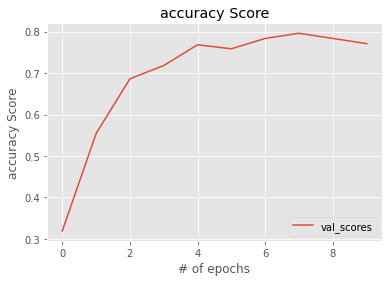

In [23]:
main(1,train_df)

Loaded pretrained weights for efficientnet-b7
FOLD :  2


19it [00:11,  1.65it/s]

=================TRAIN==================
accuracy = 0.28728070175438597,  loss = 2.00166654586792



5it [00:01,  3.81it/s]                       


=================VALID==================
accuracy = 0.37222222222222223,  loss = 1.9413403272628784
[ 1/10] train_loss: 2.00167 train_acc: 0.28728 valid_loss: 1.94134 valid_acc: 0.37222
Validation loss decreased (inf --> 1.941340).  Saving model ...


19it [00:11,  1.64it/s]

=================TRAIN==================
accuracy = 0.7258771929824561,  loss = 1.5913256406784058



5it [00:01,  3.80it/s]                       


=================VALID==================
accuracy = 0.6097222222222223,  loss = 1.6939667463302612
[ 2/10] train_loss: 1.59133 train_acc: 0.72588 valid_loss: 1.69397 valid_acc: 0.60972
Validation loss decreased (1.941340 --> 1.693967).  Saving model ...


19it [00:11,  1.61it/s]

=================TRAIN==================
accuracy = 0.837719298245614,  loss = 1.1291381120681763



5it [00:01,  3.84it/s]                       


=================VALID==================
accuracy = 0.6791666666666667,  loss = 1.3497064113616943
[ 3/10] train_loss: 1.12914 train_acc: 0.83772 valid_loss: 1.34971 valid_acc: 0.67917
Validation loss decreased (1.693967 --> 1.349706).  Saving model ...


19it [00:12,  1.57it/s]

=================TRAIN==================
accuracy = 0.9276315789473685,  loss = 0.6636374592781067



5it [00:01,  3.89it/s]                       


=================VALID==================
accuracy = 0.7138888888888889,  loss = 0.9955178499221802
[ 4/10] train_loss: 0.66364 train_acc: 0.92763 valid_loss: 0.99552 valid_acc: 0.71389
Validation loss decreased (1.349706 --> 0.995518).  Saving model ...


19it [00:11,  1.64it/s]

=================TRAIN==================
accuracy = 0.9396929824561404,  loss = 0.36539340019226074



5it [00:01,  3.79it/s]                       


=================VALID==================
accuracy = 0.7611111111111111,  loss = 0.8068162798881531
[ 5/10] train_loss: 0.36539 train_acc: 0.93969 valid_loss: 0.80682 valid_acc: 0.76111
Validation loss decreased (0.995518 --> 0.806816).  Saving model ...


19it [00:11,  1.63it/s]

=================TRAIN==================
accuracy = 0.9594298245614036,  loss = 0.21802902221679688



5it [00:01,  3.86it/s]                       


=================VALID==================
accuracy = 0.7833333333333333,  loss = 0.7499302625656128
[ 6/10] train_loss: 0.21803 train_acc: 0.95943 valid_loss: 0.74993 valid_acc: 0.78333
Validation loss decreased (0.806816 --> 0.749930).  Saving model ...


19it [00:11,  1.61it/s]

=================TRAIN==================
accuracy = 0.9967105263157895,  loss = 0.1052439883351326



5it [00:01,  3.84it/s]                       

=================VALID==================
accuracy = 0.7833333333333333,  loss = 0.7844291925430298
[ 7/10] train_loss: 0.10524 train_acc: 0.99671 valid_loss: 0.78443 valid_acc: 0.78333
EarlyStopping counter: 1 out of 5



19it [00:11,  1.65it/s]

=================TRAIN==================
accuracy = 0.9725877192982457,  loss = 0.12437675148248672



5it [00:01,  3.79it/s]                       

=================VALID==================
accuracy = 0.7833333333333333,  loss = 0.857618510723114
[ 8/10] train_loss: 0.12438 train_acc: 0.97259 valid_loss: 0.85762 valid_acc: 0.78333
EarlyStopping counter: 2 out of 5



19it [00:11,  1.65it/s]

=================TRAIN==================
accuracy = 0.9967105263157895,  loss = 0.06645363569259644



5it [00:01,  3.79it/s]                       


=================VALID==================
accuracy = 0.8083333333333333,  loss = 0.8885167241096497
[ 9/10] train_loss: 0.06645 train_acc: 0.99671 valid_loss: 0.88852 valid_acc: 0.80833
EarlyStopping counter: 3 out of 5


19it [00:11,  1.65it/s]

=================TRAIN==================
accuracy = 0.9967105263157895,  loss = 0.055972568690776825



5it [00:01,  3.81it/s]                       


=================VALID==================
accuracy = 0.7958333333333333,  loss = 0.8364161849021912
[10/10] train_loss: 0.05597 train_acc: 0.99671 valid_loss: 0.83642 valid_acc: 0.79583
EarlyStopping counter: 4 out of 5


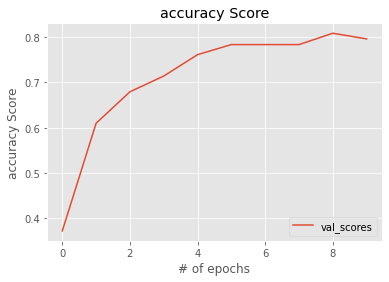

In [24]:
main(2,train_df)

Loaded pretrained weights for efficientnet-b7
FOLD :  3


19it [00:11,  1.66it/s]

=================TRAIN==================
accuracy = 0.3530701754385965,  loss = 1.9845607280731201



5it [00:01,  4.42it/s]                       


=================VALID==================
accuracy = 0.33472222222222225,  loss = 1.956600546836853
[ 1/10] train_loss: 1.98456 train_acc: 0.35307 valid_loss: 1.95660 valid_acc: 0.33472
Validation loss decreased (inf --> 1.956601).  Saving model ...


19it [00:12,  1.58it/s]

=================TRAIN==================
accuracy = 0.7203947368421053,  loss = 1.5515419244766235



5it [00:01,  4.41it/s]                       


=================VALID==================
accuracy = 0.5458333333333333,  loss = 1.6138864755630493
[ 2/10] train_loss: 1.55154 train_acc: 0.72039 valid_loss: 1.61389 valid_acc: 0.54583
Validation loss decreased (1.956601 --> 1.613886).  Saving model ...


19it [00:11,  1.61it/s]

=================TRAIN==================
accuracy = 0.8355263157894737,  loss = 1.0267795324325562



5it [00:01,  4.25it/s]                       


=================VALID==================
accuracy = 0.6930555555555555,  loss = 1.2060813903808594
[ 3/10] train_loss: 1.02678 train_acc: 0.83553 valid_loss: 1.20608 valid_acc: 0.69306
Validation loss decreased (1.613886 --> 1.206081).  Saving model ...


19it [00:11,  1.60it/s]

=================TRAIN==================
accuracy = 0.8903508771929826,  loss = 0.6357160806655884



5it [00:01,  4.27it/s]                       


=================VALID==================
accuracy = 0.7402777777777778,  loss = 0.9215901494026184
[ 4/10] train_loss: 0.63572 train_acc: 0.89035 valid_loss: 0.92159 valid_acc: 0.74028
Validation loss decreased (1.206081 --> 0.921590).  Saving model ...


19it [00:11,  1.63it/s]

=================TRAIN==================
accuracy = 0.9605263157894737,  loss = 0.33582592010498047



5it [00:01,  4.33it/s]                       


=================VALID==================
accuracy = 0.7680555555555555,  loss = 0.7527844309806824
[ 5/10] train_loss: 0.33583 train_acc: 0.96053 valid_loss: 0.75278 valid_acc: 0.76806
Validation loss decreased (0.921590 --> 0.752784).  Saving model ...


19it [00:11,  1.61it/s]

=================TRAIN==================
accuracy = 0.9802631578947368,  loss = 0.18285270035266876



5it [00:01,  4.34it/s]                       


=================VALID==================
accuracy = 0.7805555555555556,  loss = 0.6908945441246033
[ 6/10] train_loss: 0.18285 train_acc: 0.98026 valid_loss: 0.69089 valid_acc: 0.78056
Validation loss decreased (0.752784 --> 0.690895).  Saving model ...


19it [00:11,  1.59it/s]

=================TRAIN==================
accuracy = 0.9967105263157895,  loss = 0.09651166200637817



5it [00:01,  4.33it/s]                       


=================VALID==================
accuracy = 0.8527777777777779,  loss = 0.6371906399726868
[ 7/10] train_loss: 0.09651 train_acc: 0.99671 valid_loss: 0.63719 valid_acc: 0.85278
Validation loss decreased (0.690895 --> 0.637191).  Saving model ...


19it [00:12,  1.55it/s]

=================TRAIN==================
accuracy = 0.9967105263157895,  loss = 0.08315356075763702



5it [00:01,  4.30it/s]                       


=================VALID==================
accuracy = 0.8180555555555555,  loss = 0.6330471634864807
[ 8/10] train_loss: 0.08315 train_acc: 0.99671 valid_loss: 0.63305 valid_acc: 0.81806
Validation loss decreased (0.637191 --> 0.633047).  Saving model ...


19it [00:11,  1.63it/s]

=================TRAIN==================
accuracy = 0.993421052631579,  loss = 0.058626025915145874



5it [00:01,  4.33it/s]                       

=================VALID==================
accuracy = 0.8152777777777779,  loss = 0.6406263113021851
[ 9/10] train_loss: 0.05863 train_acc: 0.99342 valid_loss: 0.64063 valid_acc: 0.81528
EarlyStopping counter: 1 out of 5



19it [00:11,  1.66it/s]

=================TRAIN==================
accuracy = 0.9967105263157895,  loss = 0.04749051481485367



5it [00:01,  4.25it/s]                       


=================VALID==================
accuracy = 0.8180555555555555,  loss = 0.6440041661262512
[10/10] train_loss: 0.04749 train_acc: 0.99671 valid_loss: 0.64400 valid_acc: 0.81806
EarlyStopping counter: 2 out of 5


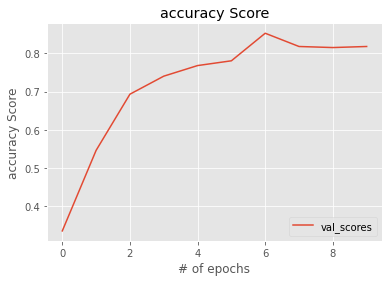

In [25]:
main(3,train_df)

Loaded pretrained weights for efficientnet-b7
FOLD :  4


19it [00:11,  1.64it/s]

=================TRAIN==================
accuracy = 0.3256578947368421,  loss = 1.9985371828079224



5it [00:01,  4.12it/s]                       


=================VALID==================
accuracy = 0.4,  loss = 1.9497547149658203
[ 1/10] train_loss: 1.99854 train_acc: 0.32566 valid_loss: 1.94975 valid_acc: 0.40000
Validation loss decreased (inf --> 1.949755).  Saving model ...


19it [00:11,  1.59it/s]

=================TRAIN==================
accuracy = 0.743421052631579,  loss = 1.5505445003509521



5it [00:01,  4.07it/s]                       


=================VALID==================
accuracy = 0.5875,  loss = 1.6438496112823486
[ 2/10] train_loss: 1.55054 train_acc: 0.74342 valid_loss: 1.64385 valid_acc: 0.58750
Validation loss decreased (1.949755 --> 1.643850).  Saving model ...


19it [00:11,  1.61it/s]

=================TRAIN==================
accuracy = 0.8618421052631579,  loss = 1.1095150709152222



5it [00:01,  4.22it/s]                       


=================VALID==================
accuracy = 0.6375,  loss = 1.2445861101150513
[ 3/10] train_loss: 1.10952 train_acc: 0.86184 valid_loss: 1.24459 valid_acc: 0.63750
Validation loss decreased (1.643850 --> 1.244586).  Saving model ...


19it [00:12,  1.57it/s]

=================TRAIN==================
accuracy = 0.9013157894736842,  loss = 0.6626089811325073



5it [00:01,  4.24it/s]                       


=================VALID==================
accuracy = 0.65,  loss = 1.010804295539856
[ 4/10] train_loss: 0.66261 train_acc: 0.90132 valid_loss: 1.01080 valid_acc: 0.65000
Validation loss decreased (1.244586 --> 1.010804).  Saving model ...


19it [00:11,  1.60it/s]

=================TRAIN==================
accuracy = 0.9407894736842105,  loss = 0.40662962198257446



5it [00:01,  4.13it/s]                       


=================VALID==================
accuracy = 0.75,  loss = 0.8029882311820984
[ 5/10] train_loss: 0.40663 train_acc: 0.94079 valid_loss: 0.80299 valid_acc: 0.75000
Validation loss decreased (1.010804 --> 0.802988).  Saving model ...


19it [00:11,  1.64it/s]

=================TRAIN==================
accuracy = 0.944078947368421,  loss = 0.26998019218444824



5it [00:01,  4.09it/s]                       


=================VALID==================
accuracy = 0.7875,  loss = 0.6962352991104126
[ 6/10] train_loss: 0.26998 train_acc: 0.94408 valid_loss: 0.69624 valid_acc: 0.78750
Validation loss decreased (0.802988 --> 0.696235).  Saving model ...


19it [00:11,  1.63it/s]

=================TRAIN==================
accuracy = 0.9802631578947368,  loss = 0.1355196237564087



5it [00:01,  4.17it/s]                       


=================VALID==================
accuracy = 0.8,  loss = 0.6417106986045837
[ 7/10] train_loss: 0.13552 train_acc: 0.98026 valid_loss: 0.64171 valid_acc: 0.80000
Validation loss decreased (0.696235 --> 0.641711).  Saving model ...


19it [00:12,  1.58it/s]

=================TRAIN==================
accuracy = 0.9901315789473685,  loss = 0.07947549223899841



5it [00:01,  4.21it/s]                       


=================VALID==================
accuracy = 0.7875,  loss = 0.5819951295852661
[ 8/10] train_loss: 0.07948 train_acc: 0.99013 valid_loss: 0.58200 valid_acc: 0.78750
Validation loss decreased (0.641711 --> 0.581995).  Saving model ...


19it [00:12,  1.58it/s]

=================TRAIN==================
accuracy = 1.0,  loss = 0.06313047558069229



5it [00:01,  4.05it/s]                       


=================VALID==================
accuracy = 0.8125,  loss = 0.5689485669136047
[ 9/10] train_loss: 0.06313 train_acc: 1.00000 valid_loss: 0.56895 valid_acc: 0.81250
Validation loss decreased (0.581995 --> 0.568949).  Saving model ...


19it [00:11,  1.62it/s]

=================TRAIN==================
accuracy = 0.9967105263157895,  loss = 0.042994771152734756



5it [00:01,  4.07it/s]                       


=================VALID==================
accuracy = 0.8,  loss = 0.5933603644371033
[10/10] train_loss: 0.04299 train_acc: 0.99671 valid_loss: 0.59336 valid_acc: 0.80000
EarlyStopping counter: 1 out of 5


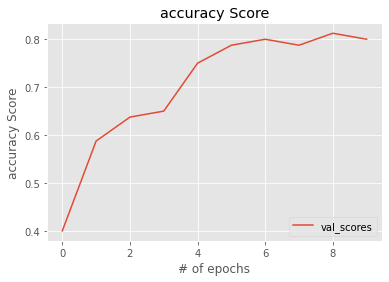

In [26]:
main(4,train_df)

In [ ]:
ls

checkpoint.pt  model_fold_0.pth  model_fold_3.pth  train_folds.csv
dataset/       model_fold_1.pth  model_fold_4.pth
drive/         model_fold_2.pth  sample_data/


In [ ]:
cp model_fold_0.pth '/content/drive/My Drive/hack_model/'

In [ ]:
!cp model_fold_1.pth '/content/drive/My Drive/hack_model/'
!cp model_fold_2.pth '/content/drive/My Drive/hack_model/'
!cp model_fold_3.pth '/content/drive/My Drive/hack_model/'
!cp model_fold_4.pth '/content/drive/My Drive/hack_model/'

In [28]:
ls dataset

test/  test.csv  train/  train.csv


Inference

In [42]:
class IndianDanceFormsDatasetTest(Dataset):
  def __init__(self, test_df, test_dir, transform=None):
    self.test_df = test_df
    self.test_dir = test_dir
    self.transform = transform
  
  def __len__(self):
    return len(self.test_df)
  
  def __getitem__(self,idx):
    row = self.test_df.loc[idx]
    img_id = row['Image']
    img = Image.open(os.path.join(self.test_dir, img_id))
    if self.transform:
      img = self.transform(img)
    return {
            'image': img
            } 

In [40]:
class EfficientNetB7(nn.Module):
    def __init__(self):
        super(EfficientNetB7, self).__init__()
        self.base_model = EfficientNet.from_name("efficientnet-b7")        
        self.l0 = nn.Linear(2560, 8)

    def forward(self, image):
        batch_size, _, _, _ = image.shape
        x = self.base_model.extract_features(image)
        x = F.adaptive_avg_pool2d(x,1).reshape(batch_size,-1)
        out = (self.l0(x))
        return out

In [60]:
test_df = pd.read_csv('dataset/test.csv')
test_dataset = IndianDanceFormsDatasetTest(
      test_df = test_df,
      test_dir = TEST_DIR,
      transform = valid_transform
)
test_loader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size= TEST_BATCH_SIZE,
        shuffle=False,
        num_workers=4
)
final_predictions = []
models = []
for fold in range(0,5):
  model = EfficientNetB7()
  model.cuda()
  model.load_state_dict(torch.load(f'model_fold_{fold}.pth'))
  model.eval()
  models.append(model)

for data in test_loader:
  image = data['image'].to(DEVICE, dtype = torch.float)
  predictions = []
  for model in models:
    with torch.no_grad():
      output = model(image)
      predictions.append(F.softmax(output, dim=1).cpu().detach().numpy())
  
  predictions = np.mean(predictions, axis=0)
  for i in range(len(image)):
    dance_pred = np.argmax(predictions[i])
    dance_form = original_values[dance_pred]
    final_predictions.append(dance_form)

In [61]:
final_submission = pd.read_csv('dataset/test.csv')
final_submission['target'] = final_predictions
final_submission.to_csv('submission.csv', index=False)
final_submission.head()

,Image,target
0,508.jpg,kuchipudi
1,246.jpg,kuchipudi
2,473.jpg,odissi
3,485.jpg,odissi
4,128.jpg,bharatanatyam
